# A|B Testing

In this notebook we'll model an A|B test on a website. We'll present version A of the website to one group of users, and version B to a different group. We expect version B to have a higher "conversion rate" or probability that a user entering that site will purchase the product being offered (a Sale).

This example is adapted from Davidson-Pilon, Cameron, *Bayesian Methods for Hackers: Probabilistic Programming and Bayesian Inference*, Addison Wesley, 2016.

### Importing the required libraries

In [1]:
import scipy.stats as stats
import numpy as np
import pymc3 as pm
import arviz as az

### Generating simulated experimental data
The Bernoulli distribution is a discrete distribution having two possible outcomes: 1 (Sale) and 0 (No Sale).  The probability mass function is given by:

$$f(x) = p^{x} (1-p)^{1-x}$$

$$\text{p is the probability of a Sale value (1)}$$

We'll use the SciPy library to generate some simulated data, and pretend we don't know the probabilities of Sales:

In [2]:
np.random.seed(579)  # <== gives the same results each time we run

#pretend we don't know these
true_p_A = 0.04      # <== probability of a Sale with version A
true_p_B = 0.05      # <== probability of a Sale with version B

#notice the unequal sample sizes -- no problem in Bayesian analysis.
Mult = 1     # <== multiplier to easily vary sample size (5 gives good result)
N_A = 750 * Mult
N_B = 1500 * Mult

#generate some observations
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
print(f"Obs from Site A: {observations_A[:30]}...")
print(f"Obs from Site B: {observations_B[:30]}...")
print(f"True p_A = {true_p_A:.3f}; sample p_A = {np.mean(observations_A):.3f}")
print(f"True p_B = {true_p_B:.3f}; sample p_B = {np.mean(observations_B):.3f}")

Obs from Site A: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]...
Obs from Site B: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]...
True p_A = 0.040; sample p_A = 0.041
True p_B = 0.050; sample p_B = 0.050


### Set up the model and run the inference engine to find delta

In [3]:
# Set up the pymc3 model. Assume Uniform priors for p_A and p_B.
with pm.Model() as model_AB:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_B - p_A)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    trace = pm.sample(20000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_B, p_A]
100%|██████████| 21000/21000 [00:13<00:00, 1546.62it/s]


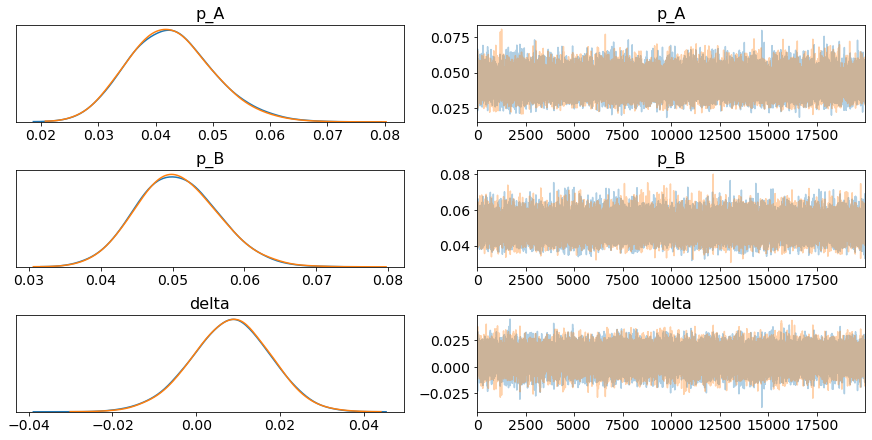

In [4]:
az.plot_trace(trace);

In [5]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p_A,0.043,0.007,0.029,0.057,0.0,0.0,43567.0,43198.0,43110.0,28416.0,1.0
p_B,0.051,0.006,0.040,0.061,0.0,0.0,38947.0,38821.0,38690.0,27192.0,1.0
delta,0.008,0.009,-0.010,0.025,0.0,0.0,41656.0,28815.0,41760.0,30857.0,1.0


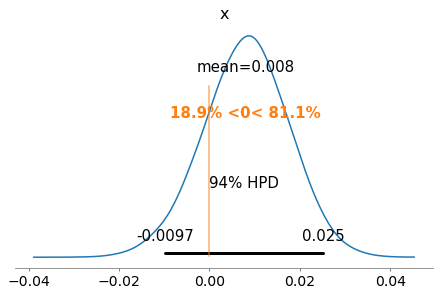

In [6]:
az.plot_posterior(trace['delta'], ref_val=0);

### Conclusion

With 750 test subjects using site A and 1500 using site B, there is a nearly 20% chance site B is not better than site A. By increasing the number of test subjects 5-fold, we estimate that there is a 97% probability that site B is an improvement